In [1]:
# add quantkit to path
import sys
from pathlib import Path
d = Path().resolve().parent.parent.parent
sys.path.insert(0, str(d))

In [53]:
import quantkit.bt as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantkit.handyman.quandl_data_loader as quandl_data_loader     
import quantkit.core.data_sources.quandl as quandl
import importlib

from datetime import datetime, timedelta

### YFinance

In [3]:
pip install yfinance==0.2.36

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.0 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=851632 sha256=9dde54888d222868e2a1aebe8eb26131833b0e77e5f58c68d6077f06d97c4a52
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [218]:
import yfinance as yf
import matplotlib.pyplot as plt

names = ["AAPL", "TSLA"]
wts = [0.5, 0.5]
df_yf = yf.download(names, start='2018-01-01', end='2023-01-01', progress=False)["Adj Close"]
df_yf = df_yf.filter(names)

df_yf.head()

,AAPL,TSLA
Date,,
2018-01-02,40.615887,21.368668
2018-01-03,40.608818,21.150000
2018-01-04,40.797436,20.974667
2018-01-05,41.261932,21.105333
2018-01-08,41.108688,22.427334


In [5]:
# return
ret_data = df_yf.pct_change()[1:]
df_ret = (ret_data * wts).sum(axis=1)
df_ret = df_ret.to_frame()
df_ret.rename(columns={0: 'return'}, inplace=True)
df_ret.head()

,return
Date,
2018-01-03,-0.005204
2018-01-04,-0.001823
2018-01-05,0.008808
2018-01-08,0.029462
2018-01-09,-0.004100


In [6]:
# cumulative return
df_cret = (df_ret + 1).cumprod()
df_cret.rename(columns={'return': 'cumulative return'}, inplace=True)

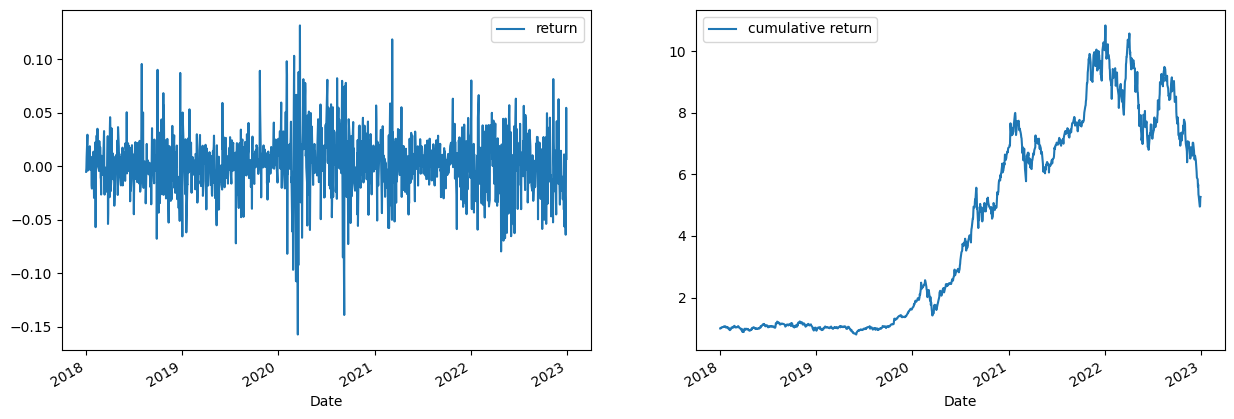

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_ret.plot(ax=axes[0], figsize=(15, 5))
df_cret.plot(ax=axes[1], figsize=(15, 5))

plt.show()

### Quandl price data

In [8]:
importlib.reload(quandl_data_loader)
importlib.reload(quandl)

names = ["AAPL", "TSLA"]

df = quandl_data_loader.get_price_data(
    names,
    start_date="2018-01-01",
    end_date="2023-01-01"    
)

df.head()

2024-05-14 16:17:54,220  WORKING ON: Batch 1/1


,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.615,172.26,2024-05-10
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.608,172.23,2024-05-10
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.796,173.03,2024-05-10
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.261,175.00,2024-05-10
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.108,174.35,2024-05-10


In [9]:
df['ticker']

0       AAPL
1       AAPL
2       AAPL
3       AAPL
4       AAPL
        ... 
2513    TSLA
2514    TSLA
2515    TSLA
2516    TSLA
2517    TSLA
Name: ticker, Length: 2518, dtype: object

In [10]:
df['1D'] = (df['closeadj']/df.groupby('ticker')['closeadj'].shift())-1
df.head()

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated,1D
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.615,172.26,2024-05-10,NaN
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.608,172.23,2024-05-10,-0.000172
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.796,173.03,2024-05-10,0.004630
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.261,175.00,2024-05-10,0.011398
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.108,174.35,2024-05-10,-0.003708


In [11]:
df = df.pivot(index='date', columns='ticker', values='1D')
df.head()

ticker,AAPL,TSLA
date,,
2018-01-02,NaN,NaN
2018-01-03,-0.000172,-0.010248
2018-01-04,0.004630,-0.008274
2018-01-05,0.011398,0.006198
2018-01-08,-0.003708,0.062639


In [12]:
df = df[1:]
df = (df * wts).sum(axis=1)
df = df.to_frame()
df.rename(columns={0: 'return'}, inplace=True)
df.head()

,return
date,
2018-01-03,-0.005210
2018-01-04,-0.001822
2018-01-05,0.008798
2018-01-08,0.029466
2018-01-09,-0.004096


<Axes: xlabel='date'>

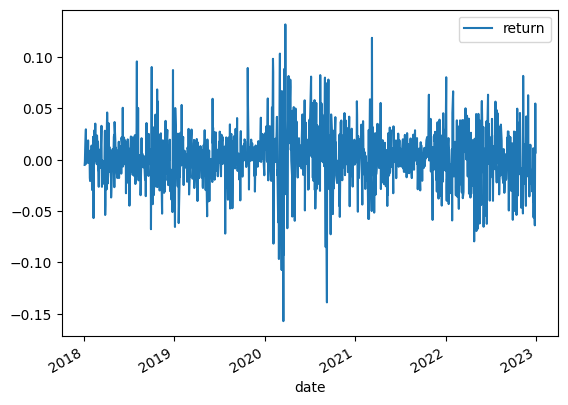

In [13]:
df.plot()

<Axes: xlabel='date'>

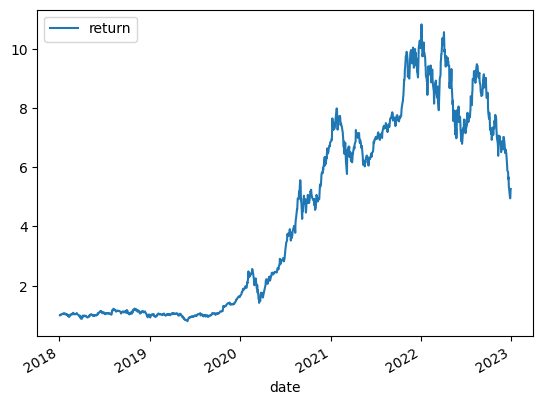

In [14]:
(df+1).cumprod(skipna=True).plot()

### Weights specified

In [10]:
df = quandl_data_loader.get_price_data(
    names,
    start_date="2018-01-01",
    end_date="2023-01-01"    
)

df = df.pivot(index='date', columns='ticker', values='closeadj')
df.reset_index(drop=False, inplace=True)
df.rename(columns={'date': 'Date'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()
df = df.rename_axis(None, axis=1).reset_index(drop=True)
df.set_index('Date', inplace=True)
df.head()

2024-05-14 16:18:04,820  WORKING ON: Batch 1/1


,AAPL,TSLA
Date,,
2018-01-02,40.615,21.369
2018-01-03,40.608,21.150
2018-01-04,40.796,20.975
2018-01-05,41.261,21.105
2018-01-08,41.108,22.427


In [11]:
import quantkit.bt.frequency as frequency
import quantkit.bt.signals as signals
import quantkit.bt.weighting_schemes as weighting_schemes
import quantkit.bt.portfolio_management as portfolio_management

import warnings
warnings.filterwarnings('ignore')

from importlib import reload
reload(bt)
reload(bt.backtest_engine)
reload(bt.backtest_engine.backtest)
reload(bt.core_structure.strategy)
reload(weighting_schemes)
reload(weighting_schemes.mvo)

<module 'quantkit.bt.weighting_schemes.mvo' from '/usr/src/quantkit/bt/weighting_schemes/mvo.py'>

In [12]:
children = [ bt.Security( name ) for name in df.columns ]

# algo to fire on the beginning of every month and to run on the first date
run_monthly_algo = frequency.RunMonthly(
    run_on_first_date=True
)

select_algo = signals.SelectAll()

# algo to set the weights in the temp dictionary\
weights = pd.Series([0.6, 0.4], index=df.columns)
weigh_specified_algo = weighting_schemes.SpecifiedWeight(**weights)

# algo to rebalance the current weights to weights set in temp dictionary
rebal_algo = portfolio_management.Rebalance()

# a strategy that rebalances monthly to specified weights
s = "monthly"
strat = bt.Strategy(
    s, 
    algos = [
        run_monthly_algo,
        select_algo, 
        weigh_specified_algo, 
        rebal_algo
    ],
    children=children
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(strat, df, integer_positions=False)

res = bt.run(backtest)

In [13]:
res.get_data()

,price,value,notional_value,cash,fees,flows
2018-01-01,100.000000,1.000000e+06,0.000000e+00,1.000000e+06,0.0,1000000.0
2018-01-02,100.000000,1.000000e+06,0.000000e+00,0.000000e+00,0.0,0.0
2018-01-03,99.579719,9.957972e+05,9.957972e+05,0.000000e+00,0.0,0.0
2018-01-04,99.529872,9.952987e+05,9.952987e+05,0.000000e+00,0.0,0.0
2018-01-05,100.460153,1.004602e+06,1.004602e+06,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...
2022-12-23,490.793288,4.907933e+06,4.907933e+06,-3.783498e-10,0.0,0.0
2022-12-27,468.159949,4.681599e+06,4.681599e+06,-3.783498e-10,0.0,0.0
2022-12-28,462.716045,4.627160e+06,4.627160e+06,-3.783498e-10,0.0,0.0
2022-12-29,483.409258,4.834093e+06,4.834093e+06,-3.783498e-10,0.0,0.0


In [14]:
res.get_weights()

,monthly,monthly>AAPL,monthly>TSLA
2018-01-01,1.0,0.000000,0.000000
2018-01-02,1.0,0.000000,0.000000
2018-01-03,1.0,0.602428,0.397572
2018-01-04,1.0,0.605521,0.394479
2018-01-05,1.0,0.606751,0.393249
...,...,...,...
2022-12-23,1.0,0.678297,0.321703
2022-12-27,1.0,0.701221,0.298779
2022-12-28,1.0,0.687704,0.312296
2022-12-29,1.0,0.676911,0.323089


In [15]:
res.get_positions()

,AAPL,TSLA
2018-01-01,0.000000,0.000000
2018-01-02,14772.867167,18718.704666
2018-01-03,14772.867167,18718.704666
2018-01-04,14772.867167,18718.704666
2018-01-05,14772.867167,18718.704666
...,...,...
2022-12-23,25454.271821,12820.917100
2022-12-27,25454.271821,12820.917100
2022-12-28,25454.271821,12820.917100
2022-12-29,25454.271821,12820.917100


### Mean-var portfolio optimization

In [50]:
names = ['AAPL', 'MSFT', 'TSLA', 'GM', 'GE', 'RSG', 'XOM', 'AIR', 'FANG']

start_date = '2023-01-01'
end_date = '2024-05-13'

df = quandl_data_loader.get_price_data(
    names,
    start_date=start_date,
    end_date=end_date    
)

df = df.pivot(index='date', columns='ticker', values='closeadj')
df.reset_index(drop=False, inplace=True)
df.rename(columns={'date': 'Date'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()
df = df.rename_axis(None, axis=1).reset_index(drop=True)
df.set_index('Date', inplace=True)
df.head()

2024-05-14 16:43:47,891  WORKING ON: Batch 1/1


,AAPL,AIR,FANG,GE,GM,MSFT,RSG,TSLA,XOM
Date,,,,,,,,,
2023-01-03,124.051,44.60,122.420,52.995,33.368,237.039,126.551,108.10,102.017
2023-01-04,125.330,45.24,121.712,55.708,34.227,226.670,126.128,113.64,102.314
2023-01-05,124.001,44.82,124.898,56.573,34.533,219.952,123.444,110.34,104.603
2023-01-06,128.564,46.09,128.719,57.088,35.430,222.545,126.237,113.06,105.868
2023-01-09,129.089,46.18,131.840,57.668,35.440,224.711,125.617,119.77,103.895


In [45]:
from importlib import reload
reload(bt)
reload(weighting_schemes)
reload(weighting_schemes.mvo)

<module 'quantkit.bt.weighting_schemes.mvo' from '/usr/src/quantkit/bt/weighting_schemes/mvo.py'>

In [58]:
children = [ bt.Security( name ) for name in df.columns ]

# algo to fire on the beginning of every month and to run on the first date
run_monthly_algo = frequency.RunMonthly(
    run_on_first_date=True
)

dt_run_after = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=2) # two days
s_dt_run_after = dt_run_after.strftime('%Y-%m-%d')

run_after_date = frequency.RunAfterDate(s_dt_run_after)

select_algo = signals.SelectAll()
options = {'disp': True}

mean_var_opt = weighting_schemes.MVOWeight(
    bounds=(0.0, 1.0), 
    covar_method='ledoit-wolf', 
    options=options)

# algo to rebalance the current weights to weights set in temp dictionary
rebal_algo = portfolio_management.Rebalance()

# a strategy that rebalances monthly to specified weights
s = "monthly"
strat = bt.Strategy(
    s, 
    algos = [
        run_monthly_algo,
        run_after_date,
        select_algo, 
        mean_var_opt, 
        rebal_algo
    ],
    children=children
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(strat, df, integer_positions=False)

res = bt.run(backtest)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8108652691951491
            Iterations: 9
            Function evaluations: 93
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5336269644705233
            Iterations: 9
            Function evaluations: 94
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.43548986685151236
            Iterations: 7
            Function evaluations: 71
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.32982940287938495
            Iterations: 6
            Function evaluations: 60
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.37316018480100593
            Iterations: 6
            Function eval

In [59]:
df_weights = res.get_weights()
df_weights

,monthly,monthly>AAPL,monthly>AIR,monthly>FANG,monthly>GE,monthly>GM,monthly>MSFT,monthly>RSG,monthly>TSLA,monthly>XOM
2023-01-02,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-01-03,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-01-04,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-01-05,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-01-06,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-05-07,1.0,0.0,0.0,0.262011,0.379278,0.031247,0.0,0.110691,0.0,0.216772
2024-05-08,1.0,0.0,0.0,0.261768,0.379963,0.031130,0.0,0.110116,0.0,0.217024
2024-05-09,1.0,0.0,0.0,0.261745,0.375946,0.031264,0.0,0.110305,0.0,0.220740
2024-05-10,1.0,0.0,0.0,0.262818,0.370987,0.031525,0.0,0.112254,0.0,0.222417


In [60]:
df_pos = res.get_positions()
df_pos

,AAPL,AIR,FANG,GE,GM,MSFT,RSG,TSLA,XOM
2023-01-02,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
2023-01-03,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
2023-01-04,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
2023-01-05,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
2023-01-06,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...
2024-05-07,0.0,0.0,1911.491565,3339.163984,1025.416458,0.0,872.297838,0.0,2772.74709
2024-05-08,0.0,0.0,1911.491565,3339.163984,1025.416458,0.0,872.297838,0.0,2772.74709
2024-05-09,0.0,0.0,1911.491565,3339.163984,1025.416458,0.0,872.297838,0.0,2772.74709
2024-05-10,0.0,0.0,1911.491565,3339.163984,1025.416458,0.0,872.297838,0.0,2772.74709


In [65]:
df_pos.loc['2024-02-01']

AAPL    0.000000e+00
AIR     0.000000e+00
FANG    0.000000e+00
GE      2.892367e+03
GM      6.610193e+03
MSFT    6.836526e+02
RSG     2.115205e+03
TSLA    1.396815e-12
XOM     0.000000e+00
Name: 2024-02-01 00:00:00, dtype: float64

In [66]:
df_weights.loc['2024-03-01']

monthly         1.000000e+00
monthly>AAPL    0.000000e+00
monthly>AIR     0.000000e+00
monthly>FANG    0.000000e+00
monthly>GE      2.793170e-01
monthly>GM      2.072155e-01
monthly>MSFT    2.172384e-01
monthly>RSG     2.962291e-01
monthly>TSLA    2.164682e-16
monthly>XOM     0.000000e+00
Name: 2024-03-01 00:00:00, dtype: float64

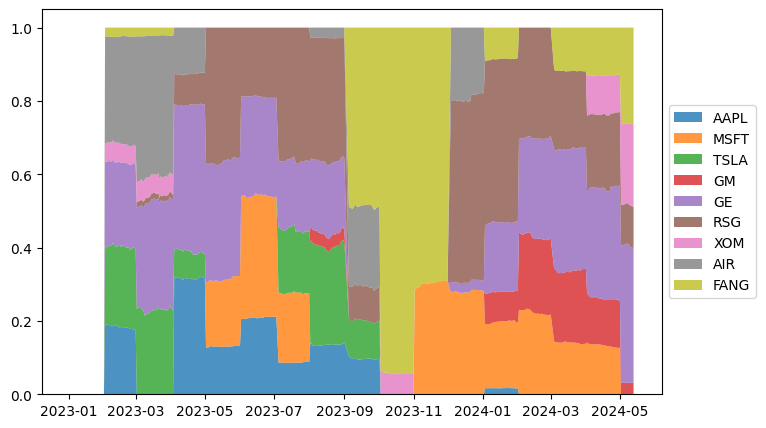

In [64]:
cols = [f'monthly>{name}' for name in names]

fig, ax = plt.subplots(figsize=(10, 5))

plt.stackplot(df_weights.index,
              df_weights[cols].T.values.tolist(),
              labels=names,
              alpha=0.8)

# Shrink current axis by 20% and place legen outside chart
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()